NOTE: Do not RUN ALL!

In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(42)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping

# IMPORT DATASETS

Plot the distribution of the original dataset

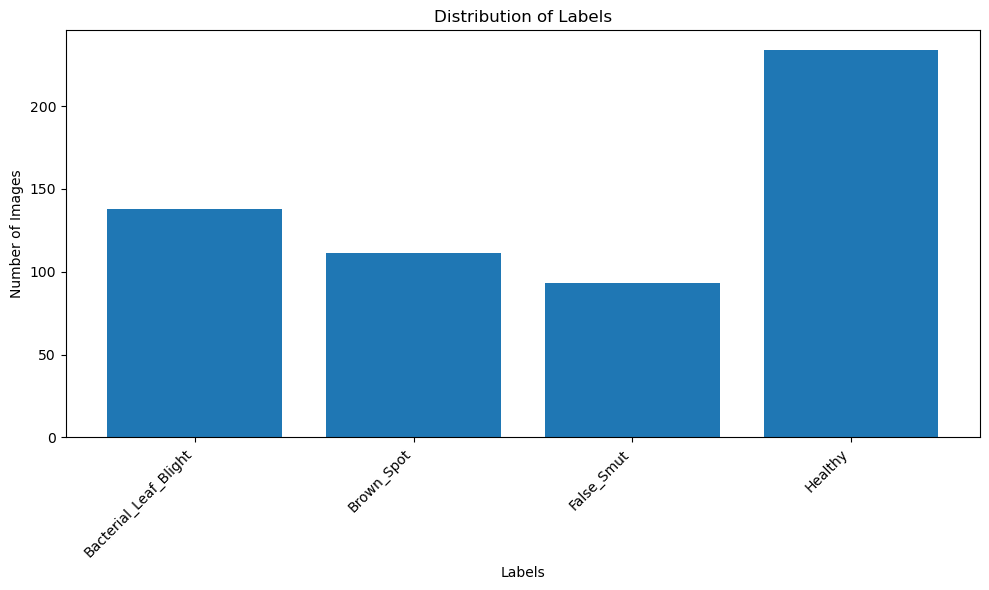

{'Bacterial_Leaf_Blight': 138, 'Brown_Spot': 111, 'False_Smut': 93, 'Healthy': 234}


In [3]:
folder_path = "Rice Disease/Data"

label_counts = {}

for label_folder in os.listdir(folder_path):
    label_folder_path = os.path.join(folder_path, label_folder)
    # Count images of each label
    num_images = len(os.listdir(label_folder_path))
    label_counts[label_folder] = num_images

# Plotting the distribution
labels = label_counts.keys()
counts = label_counts.values()

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Distribution of Labels')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(label_counts)

Overall, the dataset seems to have a good representation of different categories, with a focus on both diseased and healthy plants. While the dataset is not balanced with 40% of images labeled healthy, it is still relatively well-distributed, with no class being severely underrepresented.

Create a new dataset folder with train test split

In [4]:
# Do not re run this
# Path to the original data folder
data_folder = 'Rice Disease/Data'

# 80% for training, 20% for testing
train_split = 0.8  

# New data folders for train test splits
partitioned_data_folder = 'Rice Disease/Datasets'
os.makedirs(partitioned_data_folder, exist_ok=True)

# Iterate through each label folder
for label_folder in os.listdir(data_folder):
    label_folder_path = os.path.join(data_folder, label_folder)
    
    # Create corresponding label folders in the partitioned data folder
    train_label_folder = os.path.join(partitioned_data_folder, 'train', label_folder)
    test_label_folder = os.path.join(partitioned_data_folder, 'val', label_folder)
    os.makedirs(train_label_folder, exist_ok=True)
    os.makedirs(test_label_folder, exist_ok=True)
    
    # Get list of images in the label folder
    images = os.listdir(label_folder_path)
    random.shuffle(images)
    
    # Partition images into train and test sets
    split_index = int(len(images) * train_split)
    train_images = images[:split_index]
    test_images = images[split_index:]
    
    # Copy images to respective train and test label folders
    for image in train_images:
        src = os.path.join(label_folder_path, image)
        dst = os.path.join(train_label_folder, image)
        shutil.copy(src, dst)
        
    for image in test_images:
        src = os.path.join(label_folder_path, image)
        dst = os.path.join(test_label_folder, image)
        shutil.copy(src, dst)


Image Generator: Create different pretraining schemes (rotate, sheer, zoom)

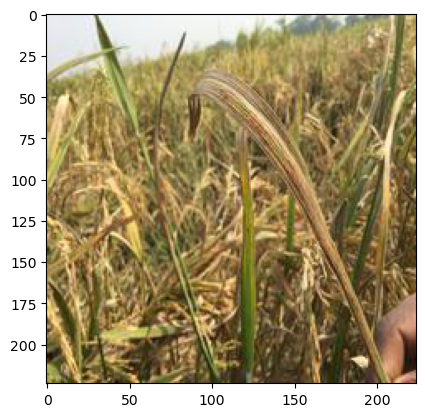

In [5]:
# Preview of how Image Generator works

datagen = ImageDataGenerator(
        rotation_range=40,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

img = load_img('Rice Disease/Data/Bacterial_Leaf_Blight/1.jpeg')  
x = img_to_array(img)  
plt.imshow(img)
x = x.reshape((1,) + x.shape)  

i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='Rice Disease/preview', save_prefix='leaf', save_format='jpeg'):
    i += 1
    if i > 20: break  

Create image generation scheme for training and validation. We try different scheme (rotation, shear, zoom, flip) for the training set and only rescale for the validation set.

In [6]:
batch_size = 16
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'Rice Disease/Datasets/train',  
    target_size=(224, 224),  
    batch_size=batch_size,
    class_mode='categorical') 

validation_generator = test_datagen.flow_from_directory(
    'Rice Disease/Datasets/val',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 459 images belonging to 4 classes.


Found 117 images belonging to 4 classes.


# MODEL TRAINING AND EVALUATION

## SELF-DEFINED METRICS

In [7]:
# Self defined F1Score metrics
from keras import backend as K

class F1Score:
    def recall(self, y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (positives + K.epsilon())
        return recall

    def precision(self, y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    def f1(self, y_true, y_pred):
        precision = self.precision(y_true, y_pred)
        recall = self.recall(y_true, y_pred)
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [8]:
# Plot metrics functions
def plot_metrics(history):
    metrics = history.keys()
    num_metrics = len(metrics) // 2
    cols = 2
    rows = (num_metrics + 1) // cols 
    if (num_metrics + 1) % cols != 0:
        rows += 1

    plt.figure(figsize=(15, 16))

    i = 0 # current plot
    for metric in metrics:
        # plot the training and validation metrics on the same plot
        if metric.startswith('val_'):
            continue  
        plt.subplot(rows, cols, i + 1)
        i += 1
        train_metric = metric
        val_metric = 'val_' + metric
        if val_metric in history:
            plt.plot(history[train_metric], label='Training ' + metric)
            plt.plot(history[val_metric], label='Validation ' + metric)
            plt.xlabel('Epochs')
            plt.ylabel(metric)
            plt.legend()
        else:
            plt.plot(history[train_metric], label=metric)
            plt.xlabel('Epochs')
            plt.ylabel(metric)
            plt.legend()

    plt.tight_layout()
    plt.show()


In [9]:
# Plot confusion matrix function
def plot_confusion_matrix(model, image_generator):
    y_true = []
    y_pred = []

    # Iterate over validation data generator and make predictions
    for i in range(len(image_generator)):
        _, batch_true = image_generator[i]  # Get a batch of data and true labels
        y_true.extend(np.argmax(batch_true, axis=1))  # One-hot encoded true labels to class indices

        batch_pred = model.predict_on_batch(image_generator[i][0])
        y_pred.extend(np.argmax(batch_pred, axis=1))  # Predicted labels

    # Compute confusion matrix
    conf_matrix = tf.math.confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.xticks(np.arange(conf_matrix.shape[1]), np.arange(conf_matrix.shape[1]))
    plt.yticks(np.arange(conf_matrix.shape[0]), np.arange(conf_matrix.shape[0]))

    plt.show()


## MODEL 1: SIMPLE ANN

First we try with a simple model with no convolutional layer

In [10]:
model1 = tf.keras.models.Sequential([
    Flatten(input_shape=(224, 224, 3)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax'),
])

model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 128)               19267712  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 19276228 (73.53 MB)
Trainable params: 192

In [11]:
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',  
              metrics=['accuracy', Precision(), Recall(), AUC(), F1Score().f1])

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

train_results = model1.fit(
    train_generator,
    steps_per_epoch=24, 
    epochs=30,
    validation_data=validation_generator,
    validation_steps=4 
)


Epoch 1/30


24/24 [==============================] - 8s 263ms/step - loss: 38.8677 - accuracy: 0.2876 - precision: 0.2876 - recall: 0.2823 - auc: 0.5340 - f1: 0.2844 - val_loss: 3.0955 - val_accuracy: 0.3125 - val_precision: 0.3065 - val_recall: 0.2969 - val_auc: 0.5882 - val_f1: 0.2990
Epoch 2/30
24/24 [==============================] - 5s 212ms/step - loss: 2.5517 - accuracy: 0.3646 - precision: 0.1897 - recall: 0.0286 - auc: 0.5616 - f1: 0.0329 - val_loss: 1.3841 - val_accuracy: 0.2656 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5497 - val_f1: 0.0000e+00
Epoch 3/30
24/24 [==============================] - 5s 200ms/step - loss: 1.8651 - accuracy: 0.3802 - precision: 0.2500 - recall: 0.0130 - auc: 0.6057 - f1: 0.0180 - val_loss: 1.3747 - val_accuracy: 0.3594 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6146 - val_f1: 0.0000e+00
Epoch 4/30
24/24 [==============================] - 5s 205ms/step - loss: 1.5523 - accuracy: 0.4169 - precision: 0.

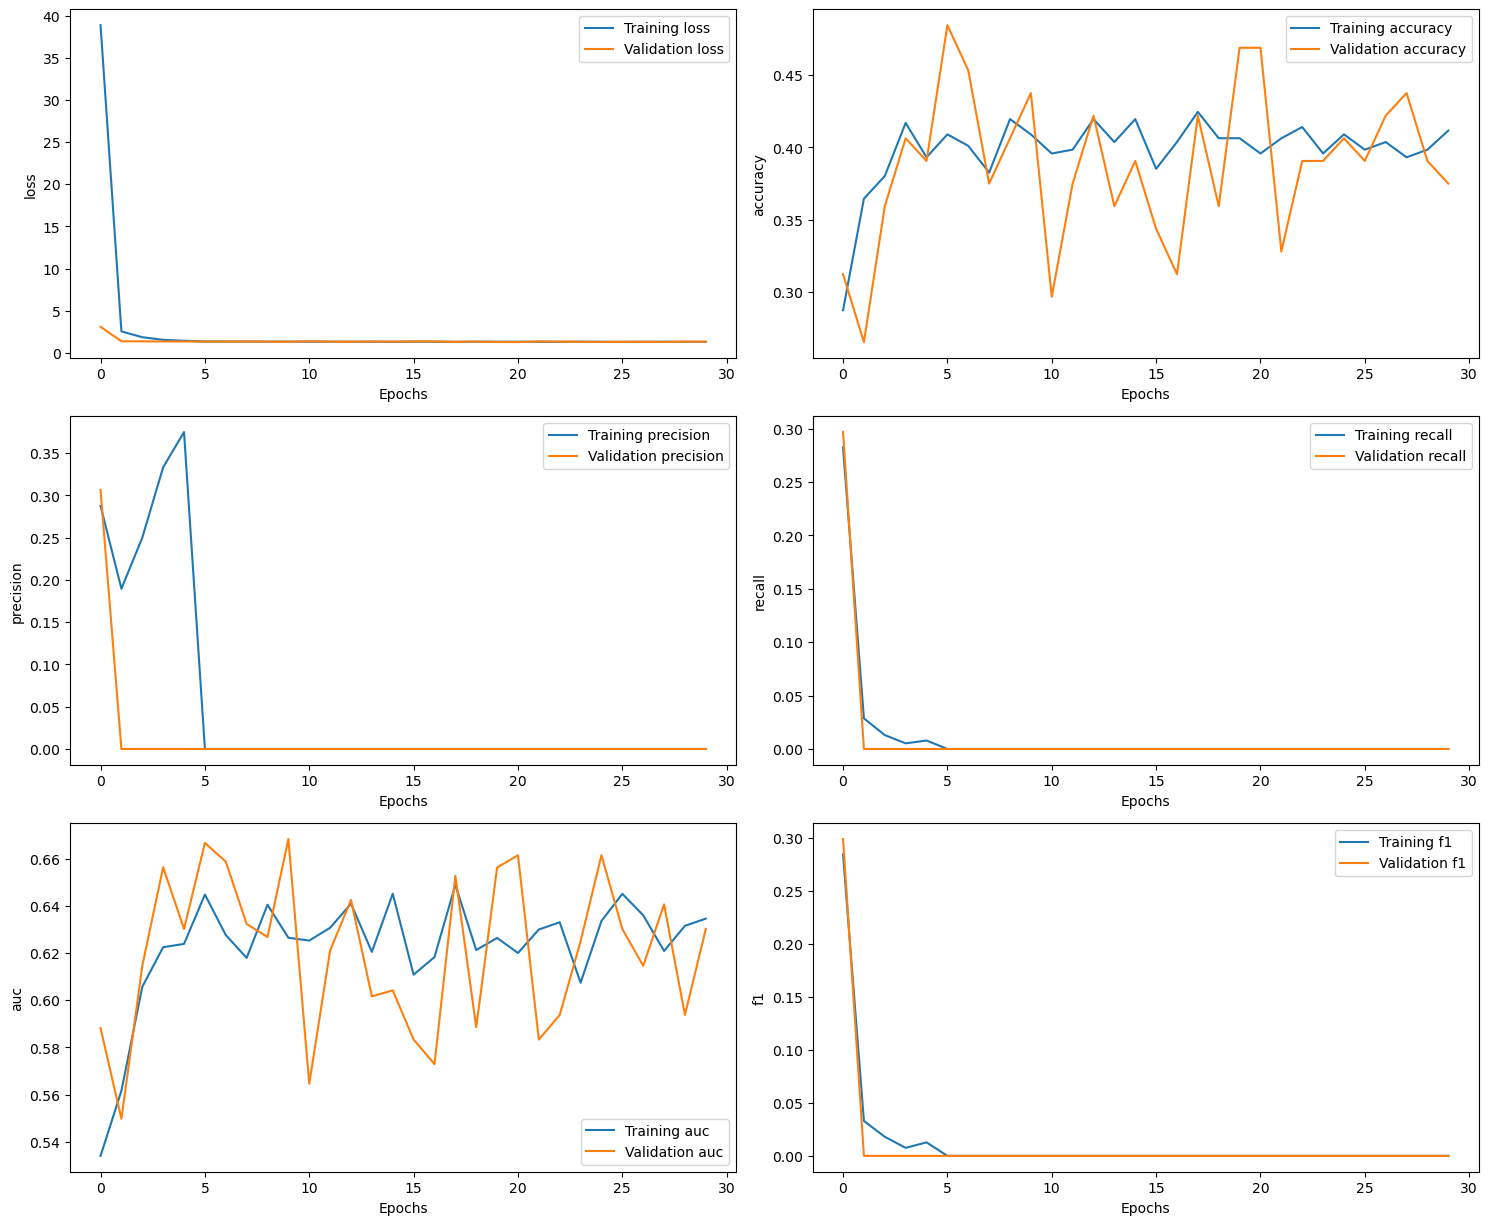

In [13]:
plot_metrics(train_results.history)

In [14]:
model1.evaluate(validation_generator)

8/8 [==============================] - 0s 21ms/step - loss: 1.3245 - accuracy: 0.4017 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6268 - f1: 0.0000e+00


[1.3244673013687134, 0.4017094075679779, 0.0, 0.0, 0.62678062915802, 0.0]

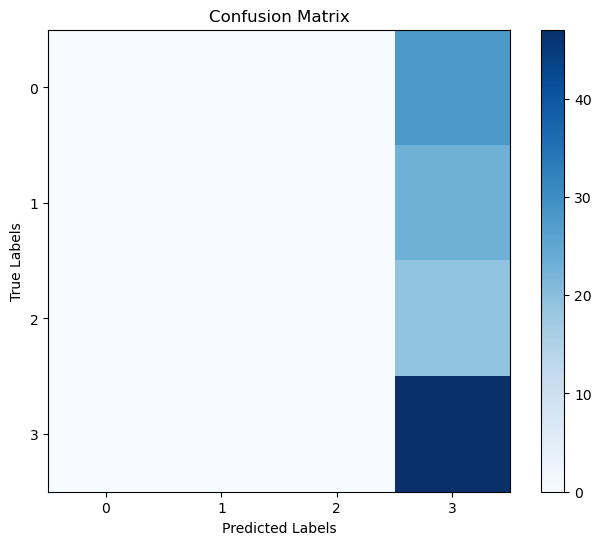

In [15]:
plot_confusion_matrix(model1, validation_generator)

From the performance metrics graph, models showing sign of underfitting with precision, recall, F1Score equal to zero in both train set and test set and fluctuation in validation loss and accuracy. 

The reason is that the model only predict all image to one labels and is too simple to learn any important features from the data. Without convolutional layers, the model is unable to capture spatial information and therefore cannot learn any features from the image.

## MODEL 2: CNN

First we try with a simple CNN model with only 2 convolutional layers, and a limited number of nodes in each layers

In [16]:
model2A = Sequential([
    Conv2D(32, kernel_size=(3, 3), input_shape=(224, 224, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax'),
])

model2A.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_3 (Dense)             (None, 64)              

In [17]:
model2A.compile(optimizer='adam',
              loss='categorical_crossentropy',  
              metrics=['accuracy', Precision(), Recall(), AUC(), F1Score().f1])

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
train_results = model2A.fit(
    train_generator,
    steps_per_epoch=24, 
    epochs=50,
    validation_data=validation_generator,
    validation_steps=4, 
    callbacks=[early_stopping]
)


Epoch 1/50
24/24 [==============================] - 9s 294ms/step - loss: 2.0561 - accuracy: 0.3826 - precision_1: 0.4286 - recall_1: 0.1425 - auc_1: 0.6088 - f1: 0.1920 - val_loss: 1.0937 - val_accuracy: 0.5781 - val_precision_1: 0.7000 - val_recall_1: 0.2188 - val_auc_1: 0.8065 - val_f1: 0.3294
Epoch 2/50
24/24 [==============================] - 6s 265ms/step - loss: 1.2278 - accuracy: 0.4301 - precision_1: 0.6508 - recall_1: 0.2164 - auc_1: 0.7084 - f1: 0.3008 - val_loss: 1.1702 - val_accuracy: 0.4375 - val_precision_1: 0.6944 - val_recall_1: 0.3906 - val_auc_1: 0.7219 - val_f1: 0.4936
Epoch 3/50
24/24 [==============================] - 6s 263ms/step - loss: 1.2562 - accuracy: 0.4327 - precision_1: 0.6505 - recall_1: 0.1768 - auc_1: 0.7055 - f1: 0.2582 - val_loss: 1.2731 - val_accuracy: 0.5625 - val_precision_1: 0.5556 - val_recall_1: 0.0781 - val_auc_1: 0.7026 - val_f1: 0.1330
Epoch 4/50
24/24 [==============================] - 6s 263ms/step - loss: 1.1873 - accuracy: 0.4723 - prec

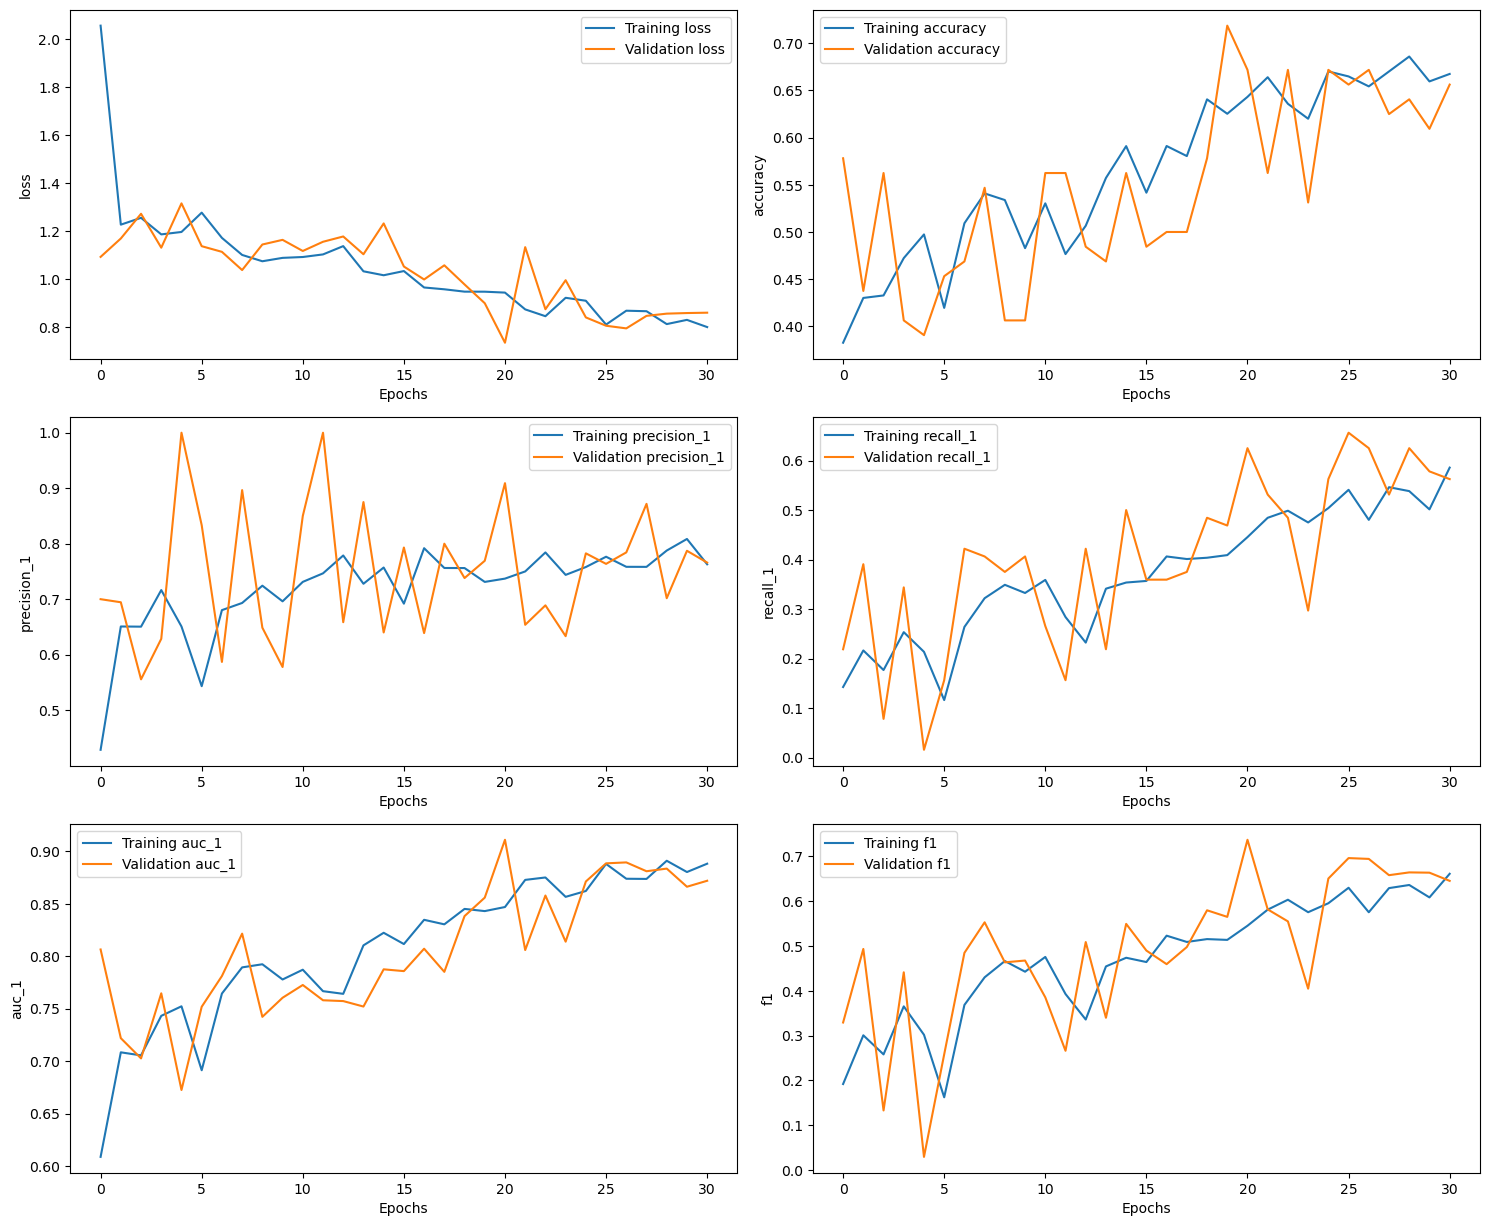

In [19]:
plot_metrics(train_results.history)

In [20]:
model2A.evaluate(validation_generator)

8/8 [==============================] - 0s 44ms/step - loss: 0.8657 - accuracy: 0.6325 - precision_1: 0.8333 - recall_1: 0.5556 - auc_1: 0.8677 - f1: 0.6895


[0.8657346963882446,
 0.632478654384613,
 0.8333333134651184,
 0.5555555820465088,
 0.8677283525466919,
 0.6894959807395935]

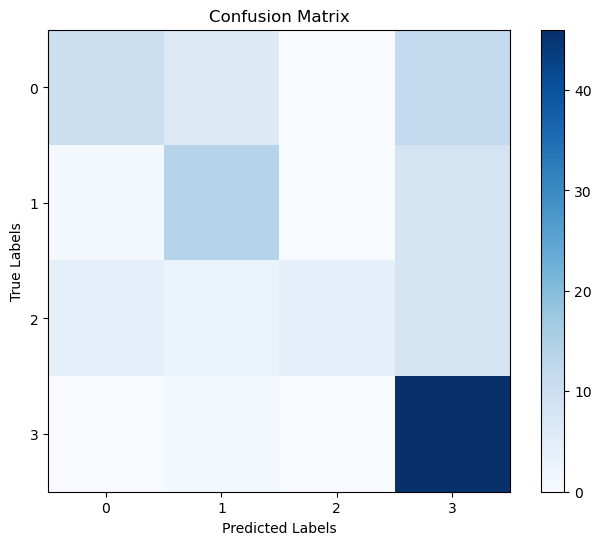

In [21]:
plot_confusion_matrix(model2A, validation_generator)

We observe a significant improvement from Model 1 as the CNN model has been able to capture the spatial information from the image and given more informed decision about the class, achieving an accuracy of 63%. However, the performance is still unstable, and the confusion matrix still show the tendency of predicting at label 3. This indicates that the model may still be underfit and simple to capture all the valuable information from the data. 

Hyperparameter tuning with keras-tuner to find more optimal hyperparameters for the model. In this model, we target validation accuracy by trying to tune the number of nodes in each layer and the dropout rate

In [22]:
import kerastuner as kt

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Choice('conv1_units', values=[32, 64, 128]), 
                            kernel_size=(3, 3), 
                            input_shape=(224, 224, 3), 
                            activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Choice('conv2_units', values=[64, 128, 256]), 
                            kernel_size=(3, 3), 
                            activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Choice('dense_units', values=[32, 64, 128]), 
                           activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='keras_tuner_dir',
                     project_name='model2A')

C:\Users\Admin\AppData\Local\Temp\ipykernel_18228\1449537806.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Perform the hyperparameter search
tuner.search(train_generator, 
             epochs=10, 
             validation_data=validation_generator, 
             callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal number of filters in the first convolutional layer: {best_hps.get('conv1_units')}")
print(f"Optimal number of filters in the second convolutional layer: {best_hps.get('conv2_units')}")
print(f"Optimal number of neurons in the dense layer: {best_hps.get('dense_units')}")
print(f"Optimal dropout rate: {best_hps.get('dropout_rate')}")

Trial 30 Complete [00h 04m 59s]
val_accuracy: 0.6068376302719116

Best val_accuracy So Far: 0.6410256624221802
Total elapsed time: 00h 41m 53s
Optimal number of filters in the first convolutional layer: 32
Optimal number of filters in the second convolutional layer: 256
Optimal number of neurons in the dense layer: 32
Optimal dropout rate: 0.30000000000000004


In [24]:
tuner.results_summary()

Results summary
Results in keras_tuner_dir\model2A
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0026 summary
Hyperparameters:
conv1_units: 32
conv2_units: 256
dense_units: 32
dropout_rate: 0.30000000000000004
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.6410256624221802

Trial 0024 summary
Hyperparameters:
conv1_units: 64
conv2_units: 128
dense_units: 128
dropout_rate: 0.2
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.6239316463470459

Trial 0028 summary
Hyperparameters:
conv1_units: 32
conv2_units: 128
dense_units: 32
dropout_rate: 0.2
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.6153846383094788

Trial 0025 summary
Hyperparameters:
conv1_units: 64
conv2_units: 64
dense_units: 64
dropout_rate: 0.30000000000000004
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023
Score: 0.6068376302719

As expected, the result from the tuning process shows that a bigger model is more effective for our task, with increasing the number of nodes in each layer and reducing the dropout rate.

In [25]:
# Build the model with the optimal hyperparameters and train it on the train dataset
model2B = tuner.hypermodel.build(best_hps)
model2B.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 256)     73984     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 256)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 746496)            0         
                                                                 
 dense_2 (Dense)             (None, 32)               

In [26]:
model2B.compile(optimizer='adam',
              loss='categorical_crossentropy',  
              metrics=['accuracy', Precision(), Recall(), AUC(), F1Score().f1])

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
train_results = model2B.fit(
    train_generator,
    steps_per_epoch=24, 
    epochs=70,
    validation_data=validation_generator,
    validation_steps=4, 
    callbacks=[early_stopping]
)

Epoch 1/70
24/24 [==============================] - 19s 738ms/step - loss: 3.6821 - accuracy: 0.3483 - precision: 0.4019 - recall: 0.1135 - auc: 0.5951 - f1: 0.1551 - val_loss: 1.2126 - val_accuracy: 0.5000 - val_precision: 0.6364 - val_recall: 0.1094 - val_auc: 0.7365 - val_f1: 0.1816
Epoch 2/70
24/24 [==============================] - 17s 698ms/step - loss: 1.2401 - accuracy: 0.4688 - precision: 0.6783 - recall: 0.2526 - auc: 0.7258 - f1: 0.3486 - val_loss: 1.2649 - val_accuracy: 0.4375 - val_precision: 1.0000 - val_recall: 0.0781 - val_auc: 0.6601 - val_f1: 0.1405
Epoch 3/70
24/24 [==============================] - 17s 685ms/step - loss: 1.1550 - accuracy: 0.4881 - precision: 0.6885 - recall: 0.2216 - auc: 0.7518 - f1: 0.3079 - val_loss: 1.1912 - val_accuracy: 0.5781 - val_precision: 0.6250 - val_recall: 0.3125 - val_auc: 0.7783 - val_f1: 0.4170
Epoch 4/70
24/24 [==============================] - 17s 694ms/step - loss: 1.0739 - accuracy: 0.5443 - precision: 0.6882 - recall: 0.3333 -

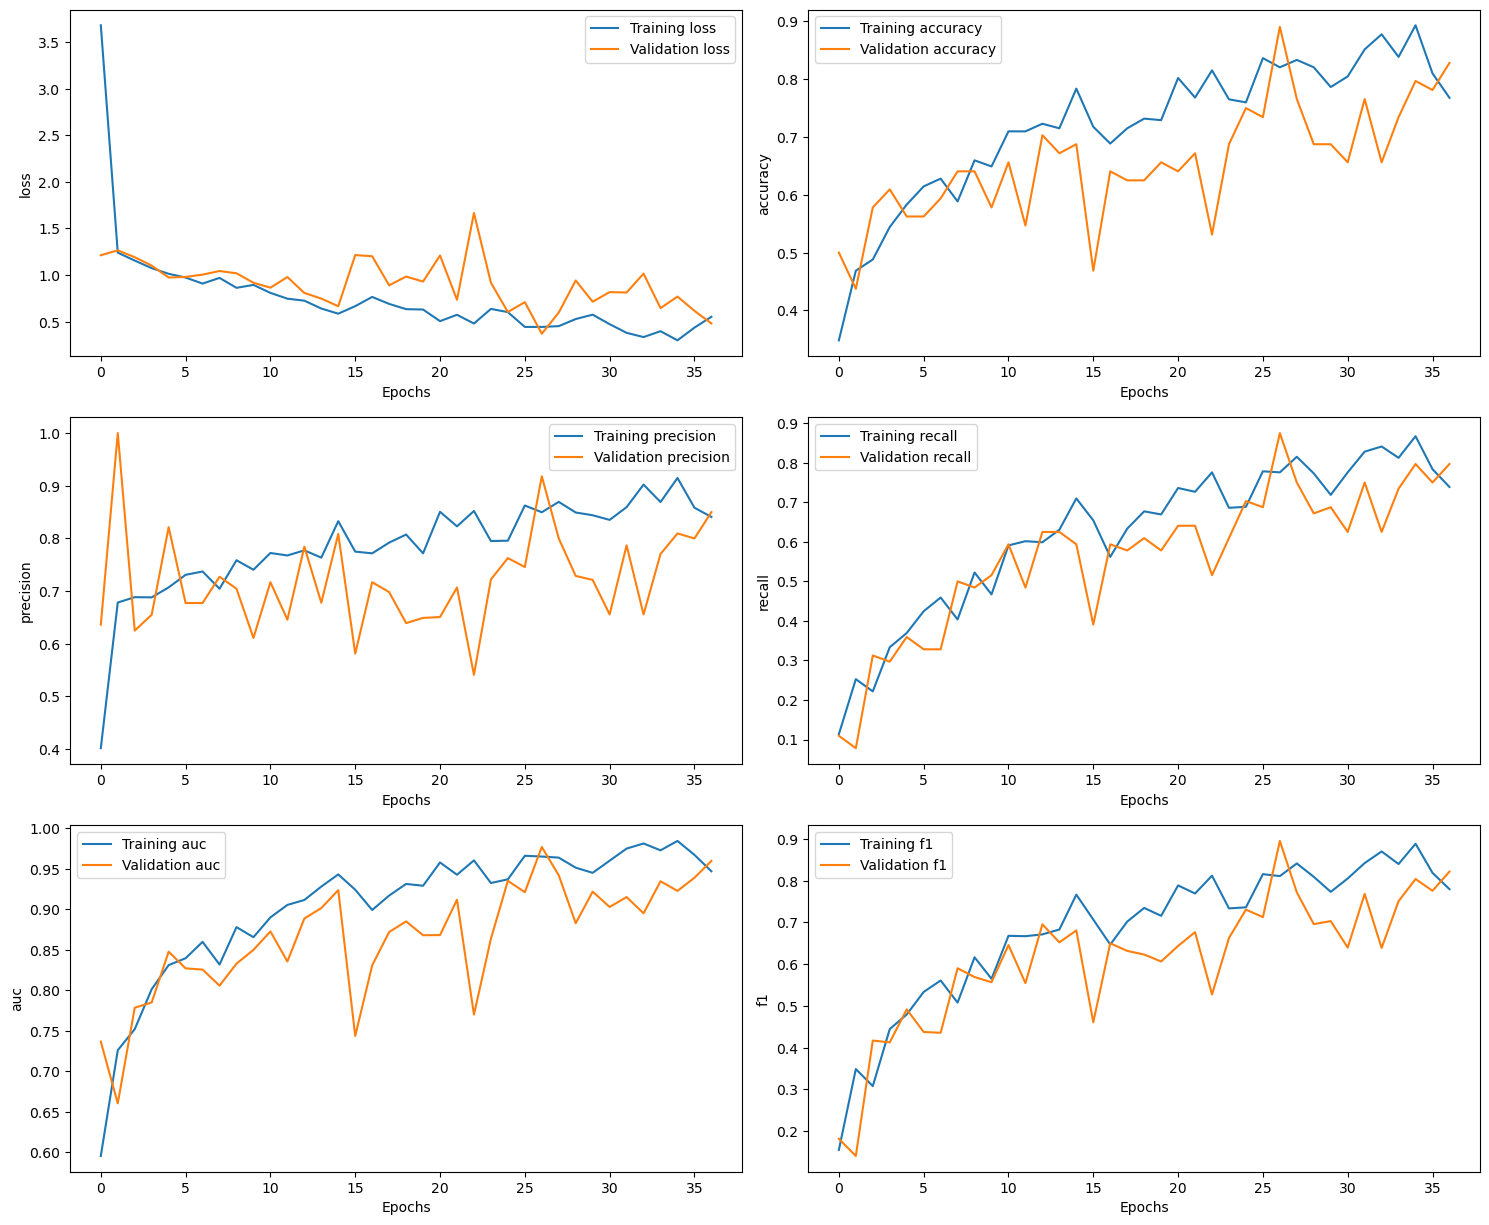

In [28]:
plot_metrics(train_results.history)

In [29]:
model2B.evaluate(validation_generator)

8/8 [==============================] - 1s 149ms/step - loss: 0.6079 - accuracy: 0.7863 - precision: 0.8173 - recall: 0.7265 - auc: 0.9376 - f1: 0.7881


[0.6078547835350037,
 0.7863247990608215,
 0.817307710647583,
 0.7264957427978516,
 0.9376019835472107,
 0.7881070971488953]

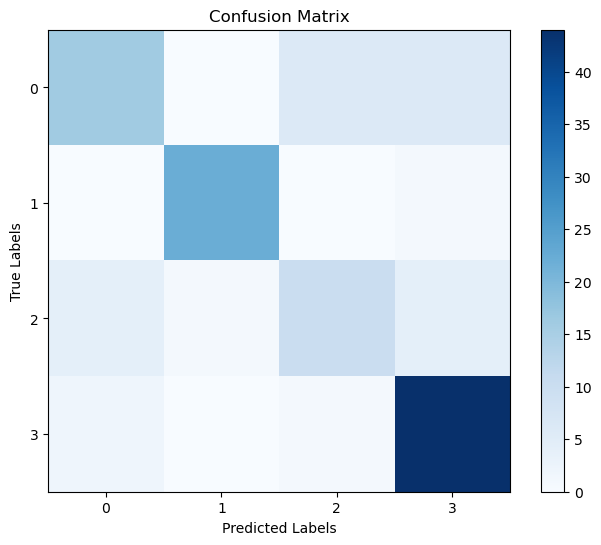

In [30]:
plot_confusion_matrix(model2B, validation_generator)

Model 2B has an improved validation accuracy of 78% and training accuracy of up to 90%. However, the validation metrics still fluctuate and unstable, with the different between train and validation metrics sometimes high, which maybe a sign of overfitting. 

Next we try to add one more convolutional layer into the model, creating Model 2C

In [31]:
model2C = Sequential([
    Conv2D(32, kernel_size=(3, 3), input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(4, activation='softmax'),
])

model2C.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 128)      

In [32]:
model2C.compile(optimizer='adam',
              loss='categorical_crossentropy',  
              metrics=['accuracy', Precision(), Recall(), AUC(), F1Score().f1])

In [33]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

train_results = model2C.fit(
    train_generator,
    steps_per_epoch=24, 
    epochs=70,
    validation_data=validation_generator,
    validation_steps=4, 
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/70
24/24 [==============================] - 11s 417ms/step - loss: 1.4296 - accuracy: 0.3773 - precision_1: 0.4490 - recall_1: 0.1741 - auc_1: 0.6148 - f1: 0.2467 - val_loss: 2.8042 - val_accuracy: 0.1875 - val_precision_1: 0.2000 - val_recall_1: 0.1875 - val_auc_1: 0.4958 - val_f1: 0.1942 - lr: 0.0010
Epoch 2/70
24/24 [==============================] - 10s 424ms/step - loss: 1.3928 - accuracy: 0.3773 - precision_1: 0.4615 - recall_1: 0.2375 - auc_1: 0.6508 - f1: 0.3106 - val_loss: 1.7998 - val_accuracy: 0.4688 - val_precision_1: 0.4909 - val_recall_1: 0.4219 - val_auc_1: 0.6792 - val_f1: 0.4532 - lr: 0.0010
Epoch 3/70
24/24 [==============================] - 10s 425ms/step - loss: 1.2304 - accuracy: 0.4609 - precision_1: 0.5425 - recall_1: 0.2995 - auc_1: 0.7254 - f1: 0.3852 - val_loss: 1.7122 - val_accuracy: 0.3438 - val_precision_1: 0.3492 - val_recall_1: 0.3438 - val_auc_1: 0.6543 - val_f1: 0.3483 - lr: 0.0010
Epoch 4/70
24/24 [==============================] - 9s 385ms/ste

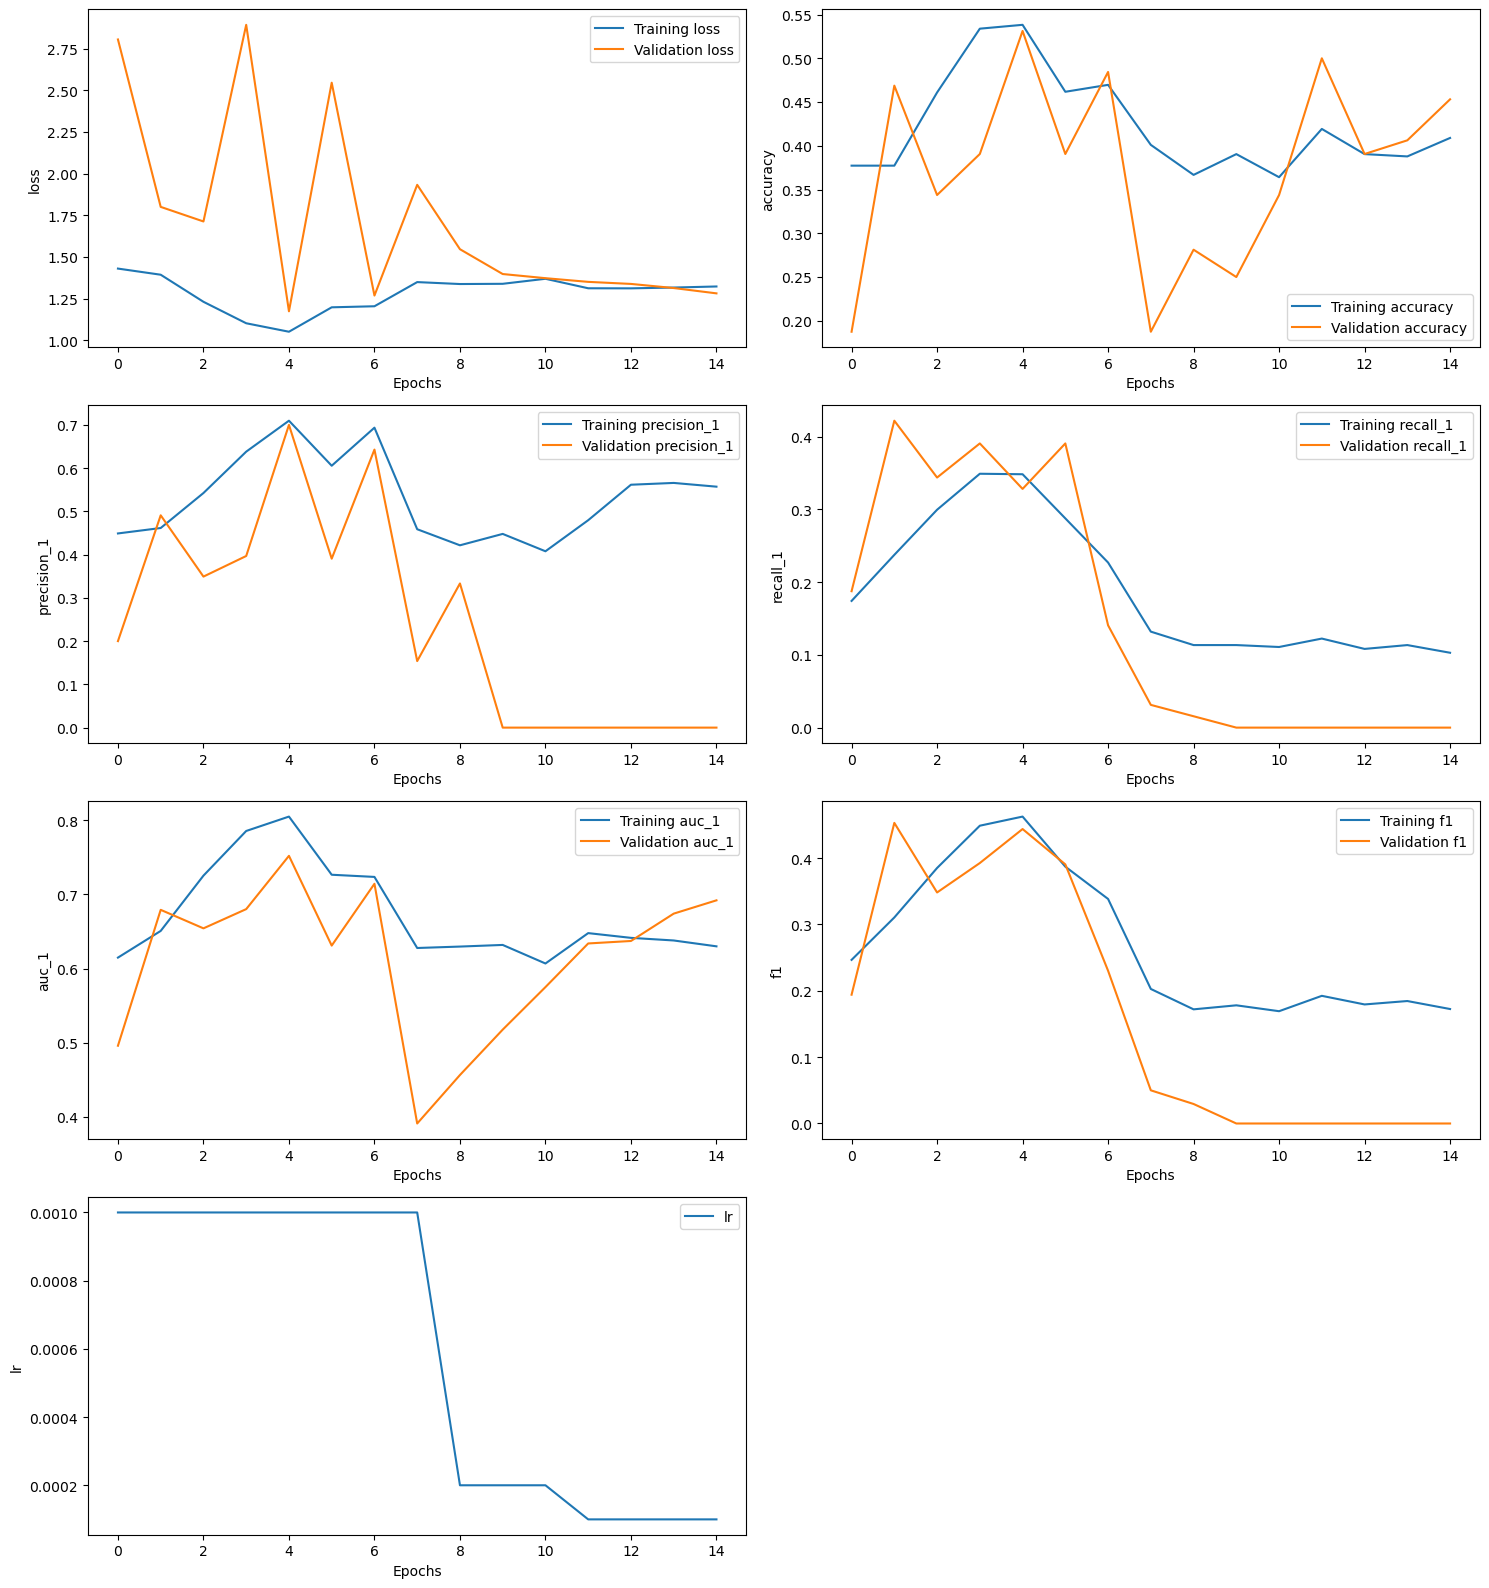

In [34]:
plot_metrics(train_results.history)

In [35]:
model2C.evaluate(validation_generator)

8/8 [==============================] - 1s 69ms/step - loss: 1.3046 - accuracy: 0.4017 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - auc_1: 0.6766 - f1: 0.0000e+00


[1.3046189546585083, 0.4017094075679779, 0.0, 0.0, 0.6765894889831543, 0.0]

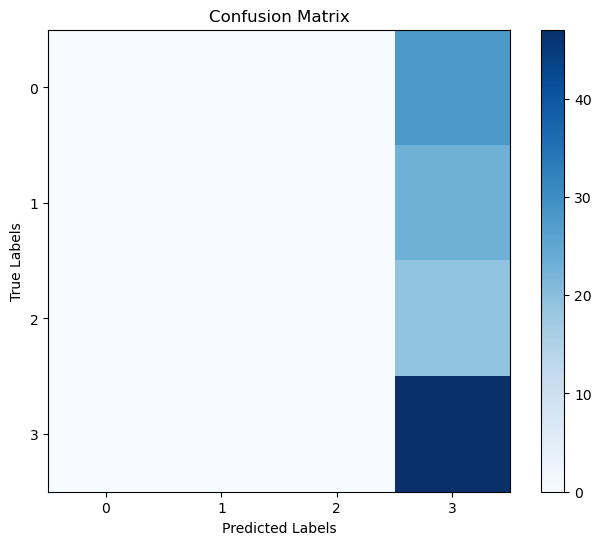

In [36]:
plot_confusion_matrix(model2C, validation_generator)

The result is that the complex models seem to work worse than the simple model. An explanation for this result is that a bigger model need more parameters, while our dataset is very limited with only about 400 images in the training set. This made complex models harder to capture the features and cannot learn much from the data.

## TRANSFER LEARNING KERAS MOBILENET

In our models, we utilized pretrained MobileNet on ImageNet as the base model without the top layer. The pretrained model here is used as a fixed feature extractor to leverage the knowledge gained from a large general dataset like ImageNet. Then we added top layers and trained only the top layers on the leaf diseases dataset for the model to learn features about our specific tasks. This is particularly useful as we only have a small data set. 

In [37]:
from tensorflow.keras.applications import MobileNet

# Load MobileNet model without top layers
base_model = MobileNet(weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False

model3 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(4, activation='softmax')
])

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, None, None, 1024   3228864   
 onal)                       )                                   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_6 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_7 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 4282564 (16.34 MB)
Trainable params: 1053700 (4.02 MB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________


In [38]:
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',  
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), F1Score().f1])

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

train_results = model3.fit(
    train_generator,
    steps_per_epoch=24, 
    epochs=30,
    validation_data=validation_generator,
    validation_steps=8, 
    callbacks=[early_stopping]
)


Epoch 1/30
24/24 [==============================] - 10s 349ms/step - loss: 0.9754 - accuracy: 0.6755 - precision_2: 0.7032 - recall_2: 0.6438 - auc_2: 0.8821 - f1: 0.6644 - val_loss: 0.5292 - val_accuracy: 0.7949 - val_precision_2: 0.8070 - val_recall_2: 0.7863 - val_auc_2: 0.9547 - val_f1: 0.7968
Epoch 2/30
24/24 [==============================] - 8s 317ms/step - loss: 0.4088 - accuracy: 0.8417 - precision_2: 0.8464 - recall_2: 0.8285 - auc_2: 0.9714 - f1: 0.8363 - val_loss: 0.2743 - val_accuracy: 0.8974 - val_precision_2: 0.9052 - val_recall_2: 0.8974 - val_auc_2: 0.9852 - val_f1: 0.9098
Epoch 3/30
24/24 [==============================] - 8s 334ms/step - loss: 0.1893 - accuracy: 0.9401 - precision_2: 0.9447 - recall_2: 0.9349 - auc_2: 0.9930 - f1: 0.9397 - val_loss: 0.1941 - val_accuracy: 0.9402 - val_precision_2: 0.9402 - val_recall_2: 0.9402 - val_auc_2: 0.9891 - val_f1: 0.9453
Epoch 4/30
24/24 [==============================] - 9s 363ms/step - loss: 0.1589 - accuracy: 0.9393 - pre

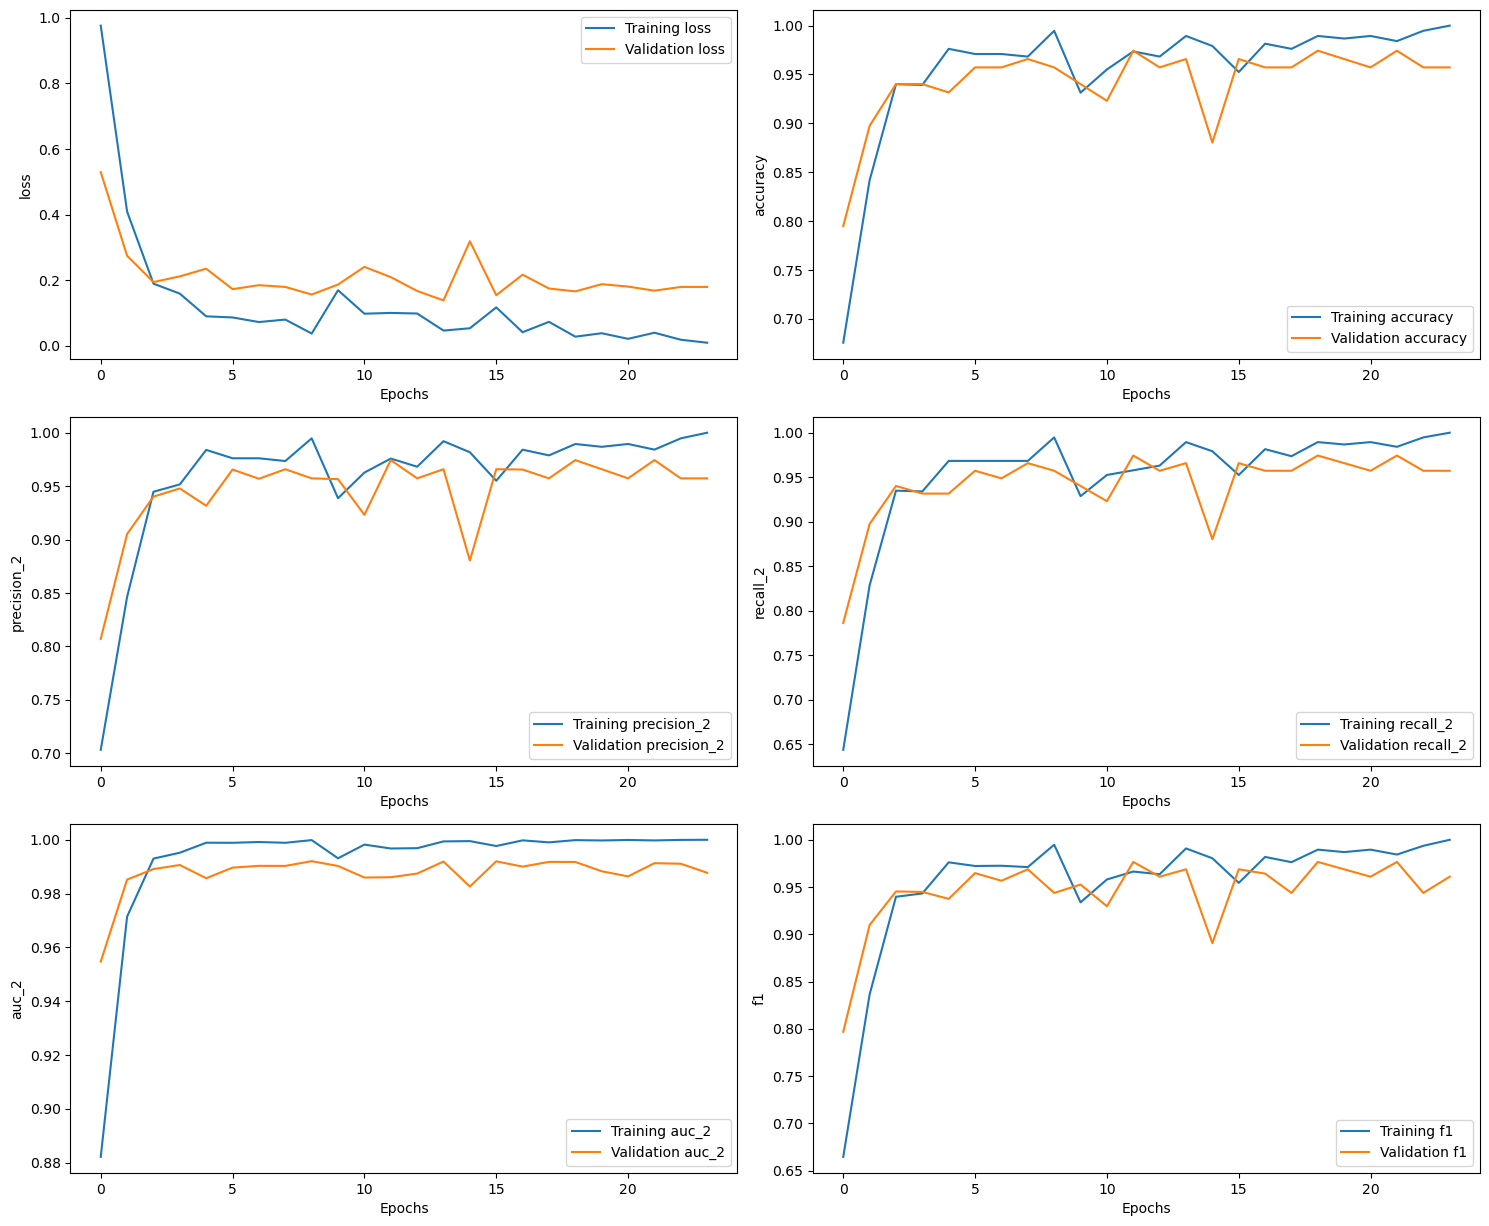

In [40]:
plot_metrics(train_results.history)

In [41]:
model3.evaluate(validation_generator)

8/8 [==============================] - 1s 88ms/step - loss: 0.1383 - accuracy: 0.9658 - precision_2: 0.9658 - recall_2: 0.9658 - auc_2: 0.9919 - f1: 0.9688


[0.13827282190322876,
 0.9658119678497314,
 0.9658119678497314,
 0.9658119678497314,
 0.9919155836105347,
 0.96875]

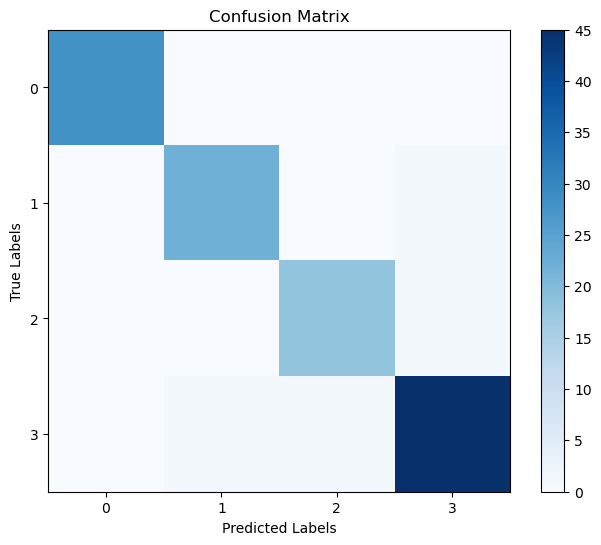

In [42]:
plot_confusion_matrix(model3, validation_generator)

Overall, this Model 3 outperformed the previous two models with up to 96% accuracy, precision, recall, and f1 score. From the loss and accuracy graph, we see that the training of the model is relatively stable, and the performance stays consistently high. This indicates that the model is good fit and generalizes well to new data in the validation set. 

## FINETUNING YOLOv8

In this final model, we fine-tuning YOLOv8 on our rice leaf dataset, adapting the pre-trained model to classify in our particular task. Different from the previous transfer learning model, finetuning involves retraining the network using our target data, allowing the model to learn the distinctive features and characteristics of the objects of interest. 

In [43]:
from ultralytics import YOLO

model4 = YOLO('yolov8n-cls.pt') 

100%|██████████| 5.30M/5.30M [00:00<00:00, 13.4MB/s]


In [44]:
model4.train(data='Rice Disease/Datasets', epochs=10)

New https://pypi.org/project/ultralytics/8.1.42 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.37 🚀 Python-3.11.5 torch-2.2.1+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=Rice Disease/Datasets, epochs=10, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, s

train: Scanning D:\IT1244 Project\Rice Disease\Datasets\train... 459 images, 0 corrupt: 100%|██████████| 459/459 [00:00<00:00, 5018.20it/s]

train: New cache created: D:\IT1244 Project\Rice Disease\Datasets\train.cache



val: Scanning D:\IT1244 Project\Rice Disease\Datasets\val... 117 images, 0 corrupt: 100%|██████████| 117/117 [00:00<00:00, 5223.68it/s]

val: New cache created: D:\IT1244 Project\Rice Disease\Datasets\val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 


optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs\classify\train
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

                   all      0.538          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all      0.692          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]

                   all      0.829          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all      0.906          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

                   all      0.923          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all      0.949          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10         0G     0.1665         11        224: 100%|██████████| 29/29 [00:13<00:00,  2.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all      0.949          1



10 epochs completed in 0.043 hours.
Optimizer stripped from runs\classify\train\weights\last.pt, 3.0MB
Optimizer stripped from runs\classify\train\weights\best.pt, 3.0MB

Validating runs\classify\train\weights\best.pt...
Ultralytics YOLOv8.1.37 🚀 Python-3.11.5 torch-2.2.1+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
YOLOv8n-cls summary (fused): 73 layers, 1440004 parameters, 0 gradients, 3.3 GFLOPs
train: D:\IT1244 Project\Rice Disease\Datasets\train... found 459 images in 4 classes ✅ 
val: D:\IT1244 Project\Rice Disease\Datasets\val... found 117 images in 4 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


                   all      0.957          1
Speed: 0.0ms preprocess, 6.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train
Results saved to runs\classify\train


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000026A73009F50>
curves: []
curves_results: []
fitness: 0.9786324799060822
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9572649598121643, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9786324799060822}
save_dir: WindowsPath('runs/classify/train')
speed: {'preprocess': 0.0, 'inference': 6.554267345330654, 'loss': 0.0, 'postprocess': 0.0}
task: 'classify'
top1: 0.9572649598121643
top5: 1.0

The YOLOv8 model has an impressive performance with accuracy vary from 0.95 to 1.00 on validation batches with just several mislabeled images. With our limited data, this has shown the power of pretrained models. 